In [1]:
# read high-level file 
import sys
sys.path.append('../')
from domains.samplers import *
# autoreload 
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import json
import warnings

# ignore below warnings
# A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
warnings.filterwarnings('ignore')


In [21]:
# command line arguments 


# Imports 
import pandas as pd
import numpy as np
import os
import json
import warnings
import argparse
import sys
sys.path.append('../')
from domains.samplers import *
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import get_additive_model_effects
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

# Define the argument parser
parser = argparse.ArgumentParser(description="Train modular neural network architectures and baselines for causal effect estimation")
parser.add_argument("--num_modules", type=int, default=10, help="Number of modules")
parser.add_argument("--num_feature_dimensions", type=int, default=100, help="Number of feature dimensions")
parser.add_argument("--num_samples", type=int, default=10000, help="Number of samples")
parser.add_argument("--module_function_type", type=str, default="mlp", help="Module function type")
parser.add_argument("--composition_type", type=str, default="parallel", help="Composition type")
parser.add_argument("--resample", type=bool, default=True, help="Resample data")
parser.add_argument("--seed", type=int, default=42, help="Seed for reproducibility")
parser.add_argument("--fixed_structure", type=bool, default=True, help="Fixed structure flag")
parser.add_argument("--data_dist", type=str, default="normal", help="Data distribution")
parser.add_argument("--heterogeneity", type=float, default=1.0, help="Heterogeneity")
parser.add_argument("--split_type", type=str, default="iid", help="Split type")
# hidden_dim
parser.add_argument("--hidden_dim", type=int, default=64, help="Hidden dimension")
# epochs
parser.add_argument("--epochs", type=int, default=100, help="Number of epochs")
# batch_size
parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
# output_dim
parser.add_argument("--output_dim", type=int, default=1, help="Output dimension")
# covariates_shared
parser.add_argument("--covariates_shared", type=str, default="True", help="Covariates shared")
# model_class
parser.add_argument("--underlying_model_class", type=str, default="MLP", help="Model class")
# run_env
parser.add_argument("--run_env", type=str, default="unity", help="Run environment")
# use_subset_features
parser.add_argument("--use_subset_features", type=str, default="False", help="Use subset of features")
# generate trees systematically for creating OOD data
parser.add_argument("--systematic", type=str, default="False", help="Systematic tree generation")

# parse arguments in jupyter notebook
args = parser.parse_args(args=[])
num_modules = args.num_modules
max_depth = num_modules
feature_dim = args.num_feature_dimensions
num_samples = args.num_samples
composition_type = args.composition_type
module_function_type = args.module_function_type
resample = args.resample
fixed_structure = args.fixed_structure
num_trees = num_samples
seed = args.seed
data_dist = args.data_dist
split_type = args.split_type    
hidden_dim = args.hidden_dim
epochs = args.epochs
batch_size = args.batch_size
output_dim = args.output_dim
data_dist = args.data_dist
covariates_shared = args.covariates_shared
underlying_model_class = args.underlying_model_class
use_subset_features = args.use_subset_features
systematic = args.systematic
if covariates_shared == "True":
    covariates_shared = True
else:
    covariates_shared = False

if use_subset_features == "True":
    use_subset_features = True
else:
    use_subset_features = False

if systematic == "True":
    systematic = True
else:
    systematic = False

domain = "synthetic_data"
# setup directories
run_env = args.run_env

if run_env == "local":
    base_dir = "/Users/ppruthi/research/compositional_models/compositional_models_cate/domains"
else:
    base_dir = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains"

main_dir = f"{base_dir}/{domain}"
csv_path = f"{main_dir}/csvs/fixed_structure_{fixed_structure}_outcomes_{composition_type}_systematic_{systematic}"
obs_data_path = f"{main_dir}/observational_data/fixed_structure_{fixed_structure}_outcomes_{composition_type}_systematic_{systematic}"


# Results Analysis

In [22]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [20]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
hl_filepath = f"{results_csv_folder}/combined_df_{data_dist}_{module_function_type}_{composition_type}_covariates_shared_{covariates_shared}_underlying_model_{underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{systematic}.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns
high_level_pehe = high_level_pehe.loc[:, ~high_level_pehe.columns.str.contains('^Unnamed')]
pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


FileNotFoundError: [Errno 2] No such file or directory: '/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/csvs/combined_df_uniform_mlp_parallel_covariates_shared_True_underlying_model_MLP_use_subset_features_False_systematic_False.csv'

# Data Creation

In [23]:
# simulate data
sampler = SyntheticDataSampler(num_modules, feature_dim, composition_type, fixed_structure, max_depth, num_trees, seed, data_dist, module_function_type, resample=resample,heterogeneity=args.heterogeneity, covariates_shared=covariates_shared, use_subset_features=use_subset_features,systematic=systematic, run_env=run_env)
sampler.simulate_data()


num_modules:  10
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Resampling data
Generating input trees
Generating input trees


KeyboardInterrupt: 

In [58]:
# read the data
data_path = f"{csv_path}/{domain}_data_high_level_features.csv"
data = pd.read_csv(data_path)
data.head()

,query_id,treatment_id,tree_depth,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,module_1_feature_feature_0,module_1_feature_feature_1,...,module_5_feature_feature_26,module_5_feature_feature_27,module_5_feature_feature_28,module_5_feature_feature_29,module_1_output,module_2_output,module_3_output,module_4_output,module_5_output,query_output
0,0,0,5,1,1,1,1,1,-6.617452,0.565670,...,-8.575329,0.470789,0.632256,0.424138,-0.795009,0.223780,-2.736805,1.767269,-0.191162,-1.731927
1,1,0,5,1,1,1,1,1,-13.808298,-5.010981,...,-3.056326,-7.798993,-12.843532,-13.040561,-2.644665,6.433252,-1.752602,-0.063609,-4.883131,-2.910754
2,2,0,5,1,1,1,1,1,-5.863821,-5.570865,...,-12.826402,-21.440468,-21.665810,-6.474852,-11.081964,4.826639,-3.273519,-0.505639,-12.129772,-22.164254
3,3,0,5,1,1,1,1,1,-2.689698,5.589500,...,-3.115236,-6.492412,7.724302,-3.643206,-0.207388,0.807550,-2.197590,0.056186,-0.928087,-2.469329
4,4,0,5,1,1,1,1,1,-5.608299,-3.291736,...,-5.523415,-2.923510,2.233183,-1.059985,-4.292824,4.103480,-0.266658,-0.099055,0.402463,-0.152594


# Data Analysis

NameError: name 'data' is not defined

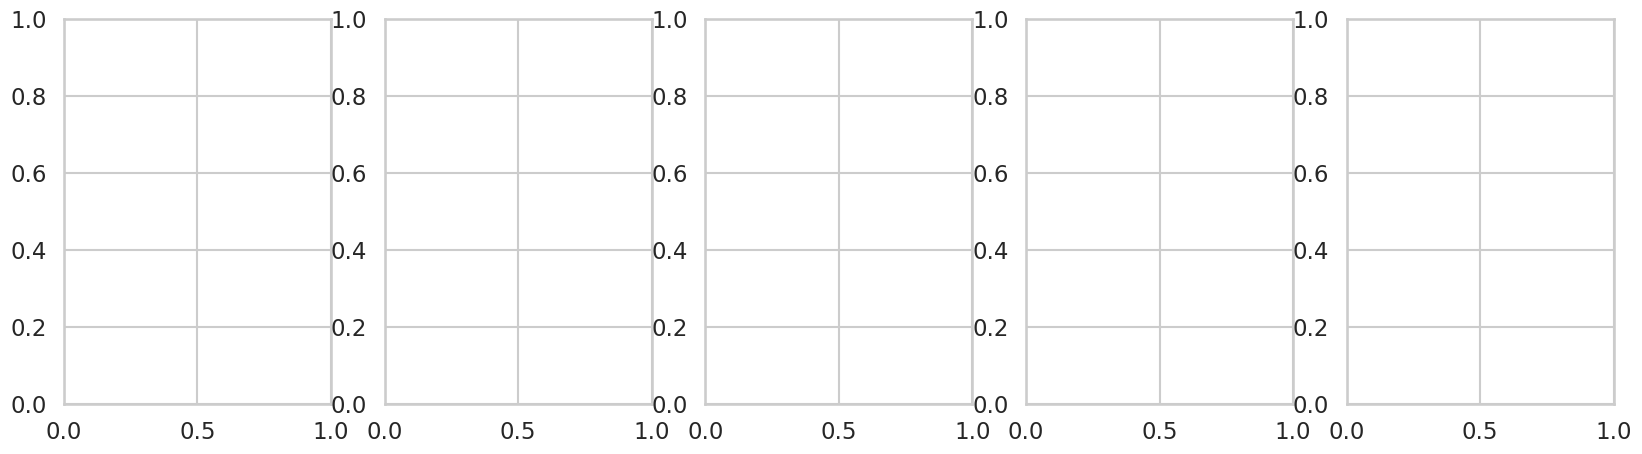

In [24]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 5
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(num_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(num_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["module_2_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



# Observational sampling

In [60]:
# Create observational data
# create observational data
results = sampler.create_observational_data(biasing_covariate="feature_sum", bias_strength=0)
df_sampled = pd.read_csv(f"{obs_data_path}/feature_sum_0/df_sampled.csv")
df_sampled.head()

,query_id,tree_depth,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,module_1_feature_feature_0,module_1_feature_feature_1,module_1_feature_feature_2,...,module_5_feature_feature_27,module_5_feature_feature_28,module_5_feature_feature_29,module_1_output,module_2_output,module_3_output,module_4_output,module_5_output,query_output,treatment_id
0,0,5,1,1,1,1,1,-6.617452,0.565670,-2.588049,...,0.470789,0.632256,0.424138,5.904489,0.742804,1.952184,3.900805,-0.136955,12.363327,1
1,1,5,1,1,1,1,1,-13.808298,-5.010981,-5.610973,...,-7.798993,-12.843532,-13.040561,-2.644665,6.433252,-1.752602,-0.063609,-4.883131,-2.910754,0
2,2,5,1,1,1,1,1,-5.863821,-5.570865,-25.071248,...,-21.440468,-21.665810,-6.474852,16.457272,8.926082,-0.714264,9.631402,-11.869736,22.430756,1
3,3,5,1,1,1,1,1,-2.689698,5.589500,-3.001898,...,-6.492412,7.724302,-3.643206,-0.207388,0.807550,-2.197590,0.056186,-0.928087,-2.469329,0
4,4,5,1,1,1,1,1,-5.608299,-3.291736,-6.362138,...,-2.923510,2.233183,-1.059985,-4.292824,4.103480,-0.266658,-0.099055,0.402463,-0.152594,0


# Train/test split

In [61]:
# split the data into features, treatment, and outcome
sampler.create_iid_ood_split(split_type = args.split_type)
# load train and test data
train_test_qids_path = f"{csv_path}/{args.split_type}/train_test_split_qids.json"
with open(train_test_qids_path, "r") as f:
    train_test_qids = json.load(f)
train_qids = train_test_qids["train"]
test_qids = train_test_qids["test"]

train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]
train_apo_df = data[data["query_id"].isin(train_qids)]
test_apo_df = data[data["query_id"].isin(test_qids)]
print(train_df.shape, test_df.shape, train_apo_df.shape, test_apo_df.shape)


# scaling 
# scale the data
sampler.create_scalers(args.split_type, biasing_covariate="feature_sum", bias_strength=0)

train depths:  []
test depths:  [5]
(9594, 164) (406, 164) (19188, 164) (812, 164)


# Data baseline model 

In [62]:
len(baseline_causal_effect_dict_test)

9594

In [63]:
len(causal_effect_estimates)

406

In [64]:
# unitary Baseline
if covariates_shared:
    covariates = [x for x in train_df.columns if "module_1_feature" in x]
else:
    covariates = [x for x in train_df.columns if "feature" in x]
treatment = "treatment_id"
outcome = "query_output"
input_dim = len(covariates)
baseline_causal_effect_dict_test = get_ground_truth_effects(data, test_qids)
if underlying_model_class == "MLP":
    # make sure hidden dim is greater than input dim
    baseline_model = BaselineModel(input_dim + 1, (input_dim + 1)*2, output_dim)
else:
    baseline_model = BaselineLinearModel(input_dim + 1, output_dim)

print("Training Baseline Model")
baseline_model, train_losses, val_losses = train_model(baseline_model, train_df, covariates, treatment, outcome, epochs, batch_size)
causal_effect_estimates = predict_model(baseline_model, test_df, covariates)
test_df.loc[:, "estimated_effect"] = causal_effect_estimates
baseline_estimated_effects = get_estimated_effects(test_df, test_qids)



# have combined df with ground truth and estimated effects based on the query_id
baseline_combined_df = pd.DataFrame.from_dict(baseline_causal_effect_dict_test, orient="index", columns=["ground_truth_effect"])
# add the estimated effects based on query ids with same order
baseline_estimated_effects_df = pd.DataFrame.from_dict(baseline_estimated_effects, orient="index", columns=["estimated_effect"])
baseline_combined_df = pd.concat([baseline_combined_df, baseline_estimated_effects_df], axis=1)

# calculate r2 score
baseline_r2 = r2_score(baseline_combined_df["ground_truth_effect"], baseline_combined_df["estimated_effect"])

Training Baseline Model
Training the model on cpu


In [50]:
print(f"Baseline R2 Score: {baseline_r2}")

Baseline R2 Score: 0.9617551582693289


In [65]:
# MoE Baseline
if underlying_model_class == "MLP":
    moe_model = MoE(input_dim+1, (input_dim + 1)*2, output_dim, num_modules)
else:
    moe_model = MoELinear(input_dim+1, output_dim, num_modules)
print("Training MoE Model")
train_model(moe_model, train_df, covariates, treatment, outcome, epochs, batch_size)
moe_causal_effect_estimates = predict_model(moe_model, test_df, covariates)
test_df.loc[:, "estimated_effect"] = moe_causal_effect_estimates
moe_estimated_effects = get_estimated_effects(test_df, test_qids)
moe_estimated_effects_df = pd.DataFrame.from_dict(moe_estimated_effects, orient="index", columns=["estimated_effect_moe"])
baseline_combined_df = pd.concat([baseline_combined_df, moe_estimated_effects_df], axis=1)

# calculate r2 score
moe_r2 = r2_score(baseline_combined_df["ground_truth_effect"], baseline_combined_df["estimated_effect_moe"])
print(f"MoE R2 Score: {moe_r2}")


Training MoE Model
Training the model on cpu
MoE R2 Score: 0.9496930823844136


In [66]:
# Explicitly modular model+
print("Training Additive Model")
print(f"Training Additive Model with hidden dim: {hidden_dim}")
additive_combined_df, module_csvs = get_additive_model_effects(csv_path, obs_data_path, train_qids, test_qids, hidden_dim=hidden_dim, epochs=epochs, batch_size=batch_size, output_dim=output_dim, underlying_model_class=underlying_model_class)


# merge the two dataframes on index
combined_df = pd.merge(baseline_combined_df, additive_combined_df, left_index=True, right_index=True, suffixes=("_baseline", "_additive"))

# calculate r2 score
additive_r2 = r2_score(combined_df["ground_truth_effect_additive"], combined_df["estimated_effect_additive"])
print(f"Additive R2 Score: {additive_r2}")

Training Additive Model
Training Additive Model with hidden dim: 64
['synthetic_data_data_high_level_features.csv', 'iid', 'module_5.csv', 'module_4.csv', 'module_1.csv', 'module_3.csv', 'module_2.csv']
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Additive R2 Score: 0.9983068612223013


# Model Evaluation

In [54]:
baseline_combined_df

,ground_truth_effect,estimated_effect,estimated_effect_moe
14,0.072841,0.161267,0.072278
41,0.013518,0.146368,0.013725
55,0.112294,0.171176,0.111663
71,0.125826,0.174574,0.126859
141,1.025055,0.951424,1.025128
...,...,...,...
9849,0.011060,0.145751,0.010718
9862,1.378858,1.234309,1.382564
9874,0.178564,0.274608,0.177928
9881,0.037208,0.152318,0.036509


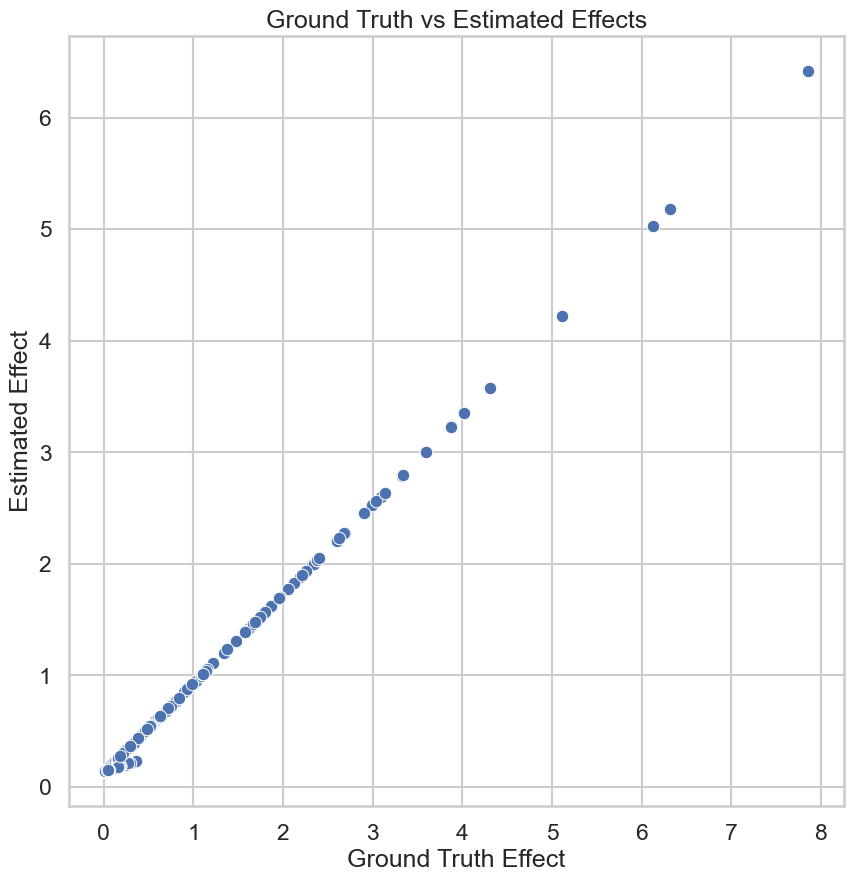

In [55]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

